In [0]:
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
import pandas as pd
import seaborn as sn
import pickle as pkl
import os
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import plot_confusion_matrix as pcm
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')
folder = '/content/drive/My Drive/601R/lab1/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
transform_train = transforms.Compose([
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [0]:
class TinyImageDataset(Dataset):
    """
    Load the Image Dataset and labels
    """
    
    def __init__(self, kind="train"):
        self.kind = kind
        root = "./tiny-imagenet-200/"
        folder = root + kind
        trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        self.dataset_folder = torchvision.datasets.ImageFolder(root,transform = trans)
        if kind == "val":
            val = pd.read_csv(folder+"/val_annotations.txt", sep="\t", header=None, names=["img","n","x","y","z","w"])
            ids = pd.read_csv(root+"wnids.txt", sep="\t", header=None, names=["n"]).reset_index().sort_values(by="n")
            self.labels = dict(val.merge(ids, how="left",on="n")["index"])
        
    def __getitem__(self,index):
        img = self.dataset_folder[index]
        if self.kind == "Val":
            label = self.labels[index]
        else:
            label = img[1]
        return img[0], label

    def __len__(self):
        return len(self.dataset_folder)

In [0]:
class BasicBlock(nn.Module):
    """
    Basic Block with 2 layers in it
    """
    expansion = 1
    
    def __init__(self, in_c, out_c, acti, b_n, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.acti = acti
        self.downsample = downsample
        
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False)
        
        if b_n:
            bn1 = nn.BatchNorm2d(in_c)
            bn2 = nn.BatchNorm2d(out_c)
            self.conv1 = nn.Sequential(bn1, self.conv1)
            self.conv2 = nn.Sequential(bn2, self.conv2)
        
        # TODO: need code for dim reduction?
        
    def forward(self, x):
        if self.downsample is not None:
            residual = self.downsample(x)
        else:
            residual = x
        
        out = self.conv1(x)
        out = self.acti(out)
        
        out = self.conv2(out)
        out += residual
        out = self.acti(out)
        
        return out
        

In [0]:
class RNN(nn.Module):
    """
    Full ResNet Model
    """
    def __init__(self, acti, b_n, weight_init, drop_out, layers=[2,3,3,1], in_c=3):
        super(RNN, self).__init__()
        
        self.drop_out = drop_out
        self.acti = acti
        self.b_n = b_n
        self.inplanes = 64
        num_classes = 10
        
        # First layer
        self.conv1 = nn.Conv2d(in_c, 64, kernel_size=7, stride=2, padding=3, bias=False)
        if b_n:
            self.conv1 = nn.Sequential(nn.BatchNorm2d(in_c), self.conv1)
            
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Middle layers
        self.layer1 = self._make_layer(BasicBlock, 64, layers[0])
        self.layer2 = self._make_layer(BasicBlock, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, layers[3], stride=2)
        
        # last layer
        self.dropout = nn.Dropout2d(p=0.5,inplace=True)
            
        # Linear Layer
        self.linear = nn.Linear(512, num_classes) 
        
        # Weight Initialization
        def init_weights(m):
            if type(m) == nn.Conv2d:
                #Xe Initialization
                if(weight_init == 1):
                    nn.init.xavier_uniform_(m.weight)
                else: #Orthogonal Optimization
                    nn.init.orthogonal_(m.weight)

        self.apply(init_weights)
            
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Conv2d(self.inplanes, planes * block.expansion,
                                    kernel_size=1, stride=stride, bias=False)
            if self.b_n:
                downsample = nn.Sequential(
                    downsample,
                    nn.BatchNorm2d(planes * block.expansion),
                )
            
        layers = []
        layers.append(block(self.inplanes, planes, self.acti, self.b_n, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, self.acti, self.b_n))

        return nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.acti(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.drop_out:
            x = self.dropout(x)
        
        x = x.view(x.size(0), -1)
        x = self.linear(x)

        return x
        

In [0]:
def train_rnn(filename, dataset, 
              epochs, batch_size, 
              acti, batch_norm, 
              lr, lr_scheduler, 
              weight_init, drop_out,
              loss_func):
    
    model = RNN(acti, batch_norm, weight_init, drop_out)

    model = model.cuda()
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    loss_func = loss_func.cuda()
        
    loader = DataLoader(dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

    if lr_scheduler:
        step_size = 4*len(loader)
        clr = cyclical_lr(step_size)
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])
    
    total_losses = []
    e_losses = []
    
    for e in range(epochs):
    
        losses = []
        
        for i, (img, label) in enumerate(loader):

            optimizer.zero_grad()
            
            y = model(img.cuda())

            loss = loss_func(y, label.cuda())
            loss.backward()
            losses.append(loss.item())
            
            optimizer.step()

            # adjust learning rate if set
            if lr_scheduler is not None:
                scheduler.step()

            if i % 100 == 0:
                total_losses.append(np.mean(losses))

        e_losses.append(np.mean(losses))
        print("--------Epoch ", e ,"--------- Loss:", e_losses[-1])

    torch.save(model.state_dict(), folder + filename + ".pt")
    return model, e_losses, total_losses

In [0]:
def plot_loss(filename, losses, total, batch_size):
    
    plt.plot(range(len(losses)), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Per Epoch")
    
    plt.savefig(filename + "_e_loss.jpg")
    plt.savefig(folder + filename + "_e_loss.jpg")
    plt.show()

    plt.plot(np.arange(len(total))*50, total)
    plt.xlabel("Batch(" + str(batch_size) +")")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    
    plt.savefig(folder + filename + "_t_loss.jpg")
    plt.show()
    
    return

In [0]:
def confusion_matrix(filename, model, plot=False):
    model.eval()
    num_classes = 10
    matrix = np.empty((num_classes,num_classes))
    
    val_data = torchvision.datasets.CIFAR10(folder,train=False,transform=transform_train)
    
    loader = DataLoader(val_data, batch_size=1)

    guesses = []
    labels = []
    
    for i, (img, label) in enumerate(loader):
        # get model guess
        y = model(img.cuda())
        guesses.append(y.argmax().item())
        labels.append(label.item())

    acc = sum(np.array(guesses) == np.array(labels))/len(guesses)
    print("Accuracy:", acc)

    # save accuracy
    acc_file = folder + filename+"_acc.txt"
    open(acc_file, 'w').write(str(acc))
        
    conf_matrix = cm(labels,guesses)

    if plot:
        plt.figure(figsize = (10,7))
        sn.heatmap(conf_matrix, annot=True)
        plt.title("Confusion Matrix for CIFAR10")
        plt.ylabel("True Class")
        plt.xlabel("Predicted Class")
        plt.savefig(folder + filename + "_confusion.jpg")
        plt.show()
    
    return conf_matrix, acc

In [0]:
def main(filename="model", plot_l=False, plot_cm=False,
         epochs=20, batch_size=256,
         acti=nn.ReLU(), batch_norm=False, 
         lr=.001, lr_scheduler=None, 
         weight_init=1, drop_out=False,
         loss_func=nn.CrossEntropyLoss()):
    
    model_file = folder + filename+".pt"
    if os.path.exists(model_file):
        acc_file = folder + filename+"_acc.txt"
        if os.path.exists(acc_file):
            return float(open(acc_file, 'r').readline())
        else:
            model = RNN(acti, batch_norm, weight_init, drop_out)
            model.load_state_dict(torch.load(model_file))
            model = model.cuda()
            
    else:
        # train
        dataset = torchvision.datasets.CIFAR10(folder, train=True, transform=transform_train)
        model, e_losses, total = train_rnn(filename, dataset,
                                    epochs, batch_size, 
                                    acti, batch_norm, 
                                    lr, lr_scheduler,
                                    weight_init, drop_out, loss_func)

        if plot_l:
            plot_loss(filename, e_losses, total,batch_size)

    # confusion matrix
    conf_matrix, acc = confusion_matrix(filename, model, plot_cm)
    
    return acc

## Part (i)

In [0]:
class LabelSmoothingLoss(nn.Module):
    """
    Loss for Label Smoothing
    """
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            # true_dist = pred.data.clone()
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

def SELU(x):
        """
            Scaled EUL function
        """
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        return scale * nn.ELU(alpha)(x)

def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [0]:
def compare_hyper_parameters(n_classes=10, plot=True):
    """

        Looks at each of the following hyperparameter/permutation and compares each of them

        Activation functions: relu (baseline), leakyrelu, selu, elu, hardshrink
        Batchnorm: off (baseline), on (use one batchnorm per residual block)
        Label smoothing: off (baseline), on
        Learning rate: constant (baseline), CLR
        Regularization: off (baseline), dropout
        Initialization: uniform(baseline),  xavier/he, orthogonal
    """
    accuracies = []

    # # Baseline
    accuracies.append(main(filename="model_base"))

    # Activation Functions
    accuracies.append(main(filename="model_selu", acti=SELU))
    accuracies.append(main(filename="model_leaky_relu", acti=nn.LeakyReLU()))
    accuracies.append(main(filename="model_elu", acti=nn.ELU()))
    accuracies.append(main(filename="model_hardshrink", acti=nn.Hardshrink()))

    # Batchnorm and dropout
    accuracies.append(main(filename="model_batch_norm", batch_norm=True))
    accuracies.append(main(filename="model_drop_out", drop_out=True))
    
    # learning and label smoothing
    accuracies.append(main(filename="model_clr_same", lr_scheduler=True))
    accuracies.append(main(filename="model_label_smoothing", loss_func=LabelSmoothingLoss(n_classes)))

    # weight initialization
    accuracies.append(main(filename="model_orthogonal", weight_init=2))

    if plot:
        labels = ["Baseline", "SeLU", "LeakyReLU", "ELU", "HardShrink", "Batch Norm", 
                    "Drop Out", "CLR", "Label Smoothing", "Orthogonal Weight Init"]
        plt.barh(range(10), accuracies,tick_label=labels)
        plt.title("Hyperparameter Testing With ResNet on CIFAR10")
        plt.savefig(folder + "Hyperparams_Bar_Graph.jpg")
        plt.show()

    return accuracies

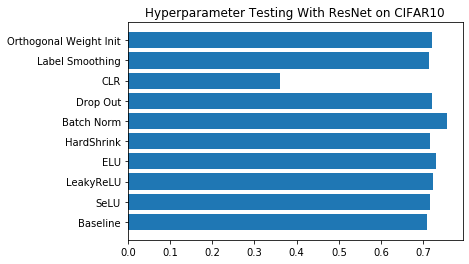

[0.7091, 0.7155, 0.7226, 0.729, 0.7167, 0.7553, 0.7201, 0.3597, 0.7129, 0.7208]

In [14]:
compare_hyper_parameters()

## Part (ii)
## Best Combination of Parameters

Looking at the accuracies of the different tweaks and hyper parameters in part i, 4-5 combinations of such parameters should be feasible. 

In general it would be reasonable to try a combination of things with batch norm as batch norm ended up with the highest accuracy of the parameter tweaks.

Strategies:
* Combine Batch Norm and ELU activation as those were two of highest accuracy measures
* Combine Batch Norm with Orthogonal Initialization
* Combine Batch Norm, Orthogonal Initialization, and ELU activation
* Combine Batch Norm, Orthogonal Initialization, ELU activation, and Label Smoothing



In [0]:
def combine_hyper_parameters(plot=True, n_classes=10):

    accuracies = []

    accuracies.append(main(filename="model_base"))

    accuracies.append(main(filename="model_batch_elu", 
                           batch_norm=True, acti=nn.ELU()))

    accuracies.append(main(filename="model_batch_orthog", 
                           batch_norm=True, weight_init=2))

    accuracies.append(main(filename="model_batch_elu_orthog", 
                           batch_norm=True, acti=nn.ELU(), weight_init=2))

    accuracies.append(main(filename="model_batch_elu_orthog_smooth", 
                           batch_norm=True, acti=nn.ELU(), 
                           weight_init=2, loss_func=LabelSmoothingLoss(n_classes)))


    if plot:
        labels = ["Baseline", "Batch Norm/ELU", "Batch Norm/Orthogonal Init",
                    "Batch Norm/ELU/Orthogonal Init", "Batch Norm/ELU/Orthogonal Init/Label Smoothing"]
        plt.barh(range(5), accuracies,tick_label=labels)
        plt.title("Hyperparameter Combining With ResNet on CIFAR10")
        plt.savefig(folder + "Hyperparams_Combine_Bar_Graph.jpg")
        plt.show()

    return accuracies


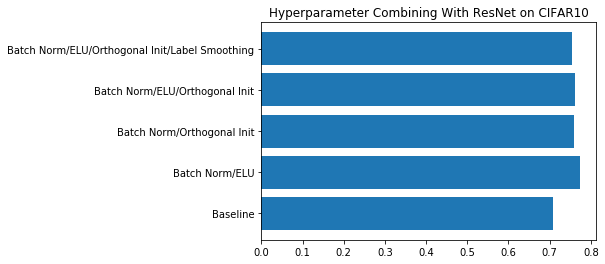

[0.7091, 0.7743, 0.7587, 0.7608, 0.7538]

In [16]:
combine_hyper_parameters()

Interestingly enough the batch norm with the ELU without anything else had the highest accuracy.